In [204]:
import pandas as pd
import os
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def extract_ko_from_emapper(fin_emapper, fin_mapping):
    """
    function to extract KEGG_ko from a list of KEGG_ko
    """
    # import emapper output
    df = pd.read_csv(fin_emapper, sep="\t")
    df = df[["query", "KEGG_ko"]].copy()

    # select rows that KEGG_ko is not "-", and query is started with "Y1_", "Y2_", or "Y3_"
    emapper = df[(df["KEGG_ko"] != "-") & (df["query"].str.startswith("Y1_") | df["query"].str.startswith("Y2_") | df["query"].str.startswith("Y3_"))].copy()

    pc_mapping = pd.read_csv(fin_mapping, sep="\t", header=None, names=["repid", "protid"])
    emapper_pc = pc_mapping.merge(emapper, left_on="protid", right_on="query", how="inner")

    emapper_repid2ko = emapper_pc[["repid", "KEGG_ko"]].copy()
    emapper_repid2ko = emapper_repid2ko.drop_duplicates()

    # merge mmseqs2 clusters with eggnog KEGG_ko
    rst = pc_mapping.merge(emapper_repid2ko, on="repid", how="inner")
    rst = rst[["protid", "KEGG_ko"]].copy()
    rst = rst.drop_duplicates()

    # replace "__" in protid with "_"
    rst["protid"] = rst["protid"].str.replace("__", "_")

    # split KEGG_ko by ",", and add a new row for each KEGG_ko
    rst = rst.set_index(rst.columns.drop("KEGG_ko",1).tolist()).KEGG_ko.str.split(",", expand=True).stack().reset_index().rename(columns={0:"KEGG_ko"})

    # select protid and KEGG_ko
    rst = rst[["protid", "KEGG_ko"]].copy()
    rst = rst.drop_duplicates()

    # remove "ko:"
    rst["KEGG_ko"] = rst["KEGG_ko"].str.replace("ko:", "")
    
    return rst

### Virome metabolic pathways

In [205]:
fin_emapper = "all_eggnog.tsv.gz"
fin_mapping = "clst_s30_c80_cluster.tsv.gz"

fout_prot2ko = "prot2ko.tsv"
fout_keggdecoder_virome = "keggdecoder_virome.tsv"
fout_heatmap_virome = "heatmap_virome.png"

fout_prot2ko_16s = "prot2ko_16s.tsv"
fout_keggdecoder_16s = "keggdecoder_16s.tsv"
fout_heatmap_16s = "heatmap_16s.png"

# extract KEGG_ko from eggnog
rst = extract_ko_from_emapper(fin_emapper, fin_mapping)

# write to file without header
rst.to_csv(fout_prot2ko, sep="\t", header=False, index=False)

In [206]:
# run command "KEGG-decoder --input prot2ko.tsv --output out.list --vizoption interactive" using subprocess.run
subprocess.run(["KEGG-decoder", "--input", fout_prot2ko, "--output", fout_keggdecoder_virome, "--vizoption", "interactive"])

CompletedProcess(args=['KEGG-decoder', '--input', 'prot2ko.tsv', '--output', 'keggdecoder_virome.tsv', '--vizoption', 'interactive'], returncode=0)

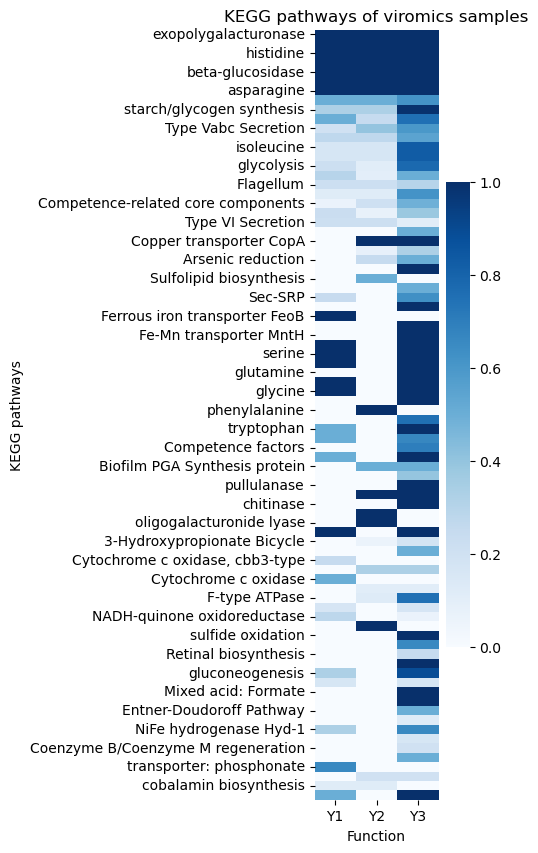

In [207]:
# read keggdecoder output
df_kegg_virome = pd.read_csv(fout_keggdecoder_virome, sep="\t", index_col=0)

# remove columns that has sum of values less than 0.1
df_kegg_virome = df_kegg_virome.loc[:, (df_kegg_virome.sum(axis=0) > 0.1)].T

# sort df_kegg_virome by product of row values
df_kegg_virome = df_kegg_virome.reindex(df_kegg_virome.product(axis=1).sort_values(ascending=False).index)

# plot heatmap of df_kegg_virome2
fig, ax = plt.subplots(figsize=(2, 10))
sns.heatmap(df_kegg_virome, cmap="Blues", ax=ax)

# add title to figure
ax.set_title("KEGG pathways of viromics samples")

# change y axis label to "KEGG pathways"
ax.set_ylabel("KEGG pathways")

# save figure
fig.savefig(fout_heatmap_virome, bbox_inches="tight", pad_inches=0.1, dpi=600)

### 16s METACYC pathways

In [208]:
fin_picrust_metacyc = "picrust/METACYC_path_abun_unstrat_descrip.tsv"

df_picrust_metacyc = pd.read_csv(fin_picrust_metacyc, sep="\t")

# remove column description
df_picrust_metacyc = df_picrust_metacyc.drop(columns=["pathway"])

# set index to function
df_picrust_metacyc = df_picrust_metacyc.set_index("description")

# sort df_picrust_metacyc by sum of row values
df_picrust_metacyc = df_picrust_metacyc.reindex(df_picrust_metacyc.sum(axis=1).sort_values(ascending=False).index)

# log transform df_picrust_metacyc
df_picrust_metacyc_log = np.log2(df_picrust_metacyc+1)

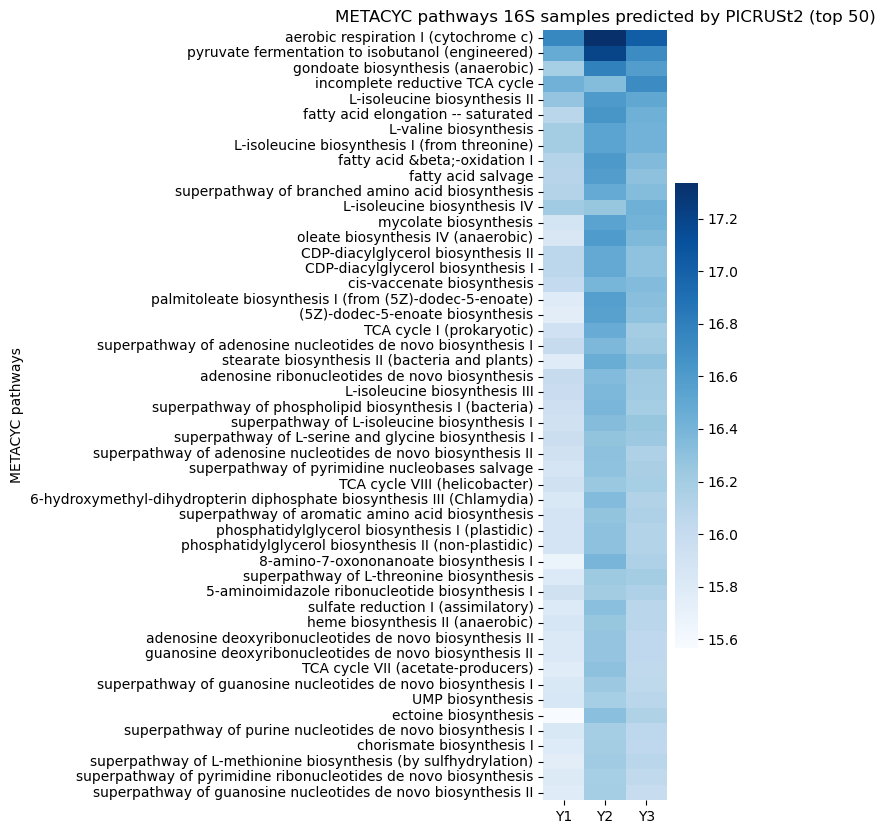

In [239]:
# plot heatmap of df_picrust_metacyc top 50 rows
fig, ax = plt.subplots(figsize=(2, 10))
sns.heatmap(df_picrust_metacyc_log.iloc[:50, :], cmap="Blues", ax=ax)

# add title to figure
ax.set_title("METACYC pathways 16S samples predicted by PICRUSt2 (top 50)")

# change y axis label to "METACYC pathways"
ax.set_ylabel("METACYC pathways")

# save figure
fig.savefig("metacyc_"+fout_heatmap_16s, bbox_inches="tight", pad_inches=0.1, dpi=600)

In [231]:
fin_picrust_ko = "picrust/KO_pred_metagenome_unstrat_descrip.tsv"

df_picrust = pd.read_csv(fin_picrust_ko, sep="\t")

# remove column description
df_picrust = df_picrust.drop(columns=["description"])

# set index to function
df_picrust = df_picrust.set_index("function")

# sort df_picrust by sum of row values
df_picrust = df_picrust.reindex(df_picrust.sum(axis=1).sort_values(ascending=False).index)

# if value > 10, set value to 10, else set value to 0
df_picrust = df_picrust.applymap(lambda x: 10 if x > 10000 else 0)

# remove rows that has sum of values less than 10
df_picrust = df_picrust.loc[(df_picrust.sum(axis=1) >= 10), :]

# convert to dictionary
dict_picrust = df_picrust.to_dict(orient="index")

rst = []
for k, v in dict_picrust.items():
    for k2, v2 in v.items():
        if v2 > 0:
            rst.append(["{}_{}".format(k2, k), k])

df_rst = pd.DataFrame(rst, columns=["protid", "KEGG_ko"])

# remove duplicate rows
df_rst = df_rst.drop_duplicates()

# write to file without header
df_rst.to_csv(fout_prot2ko_16s, sep="\t", header=False, index=False)

In [232]:
# run command "KEGG-decoder --input prot2ko.tsv --output out.list --vizoption interactive" using subprocess.run
subprocess.run(["KEGG-decoder", "--input", fout_prot2ko_16s, "--output", fout_keggdecoder_16s, "--vizoption", "interactive"])

CompletedProcess(args=['KEGG-decoder', '--input', 'prot2ko_16s.tsv', '--output', 'keggdecoder_16s.tsv', '--vizoption', 'interactive'], returncode=0)

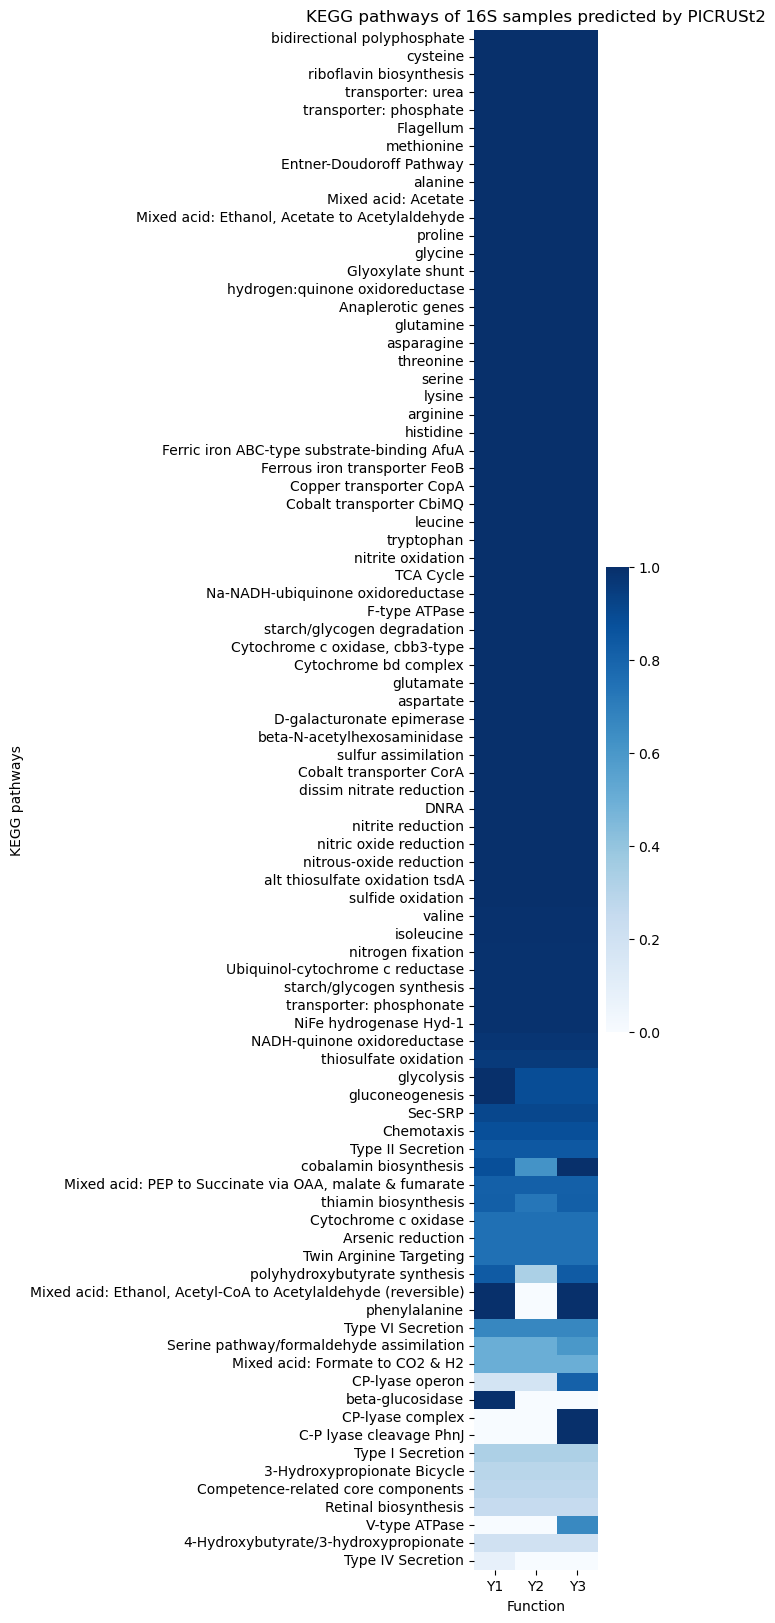

In [238]:
# read keggdecoder output
df_kegg_16s = pd.read_csv(fout_keggdecoder_16s, sep="\t", index_col=0)

# remove columns that has product of values less than 0.1
df_kegg_16s = df_kegg_16s.loc[:, (df_kegg_16s.sum(axis=0) > 0.01)].T

# sort df_kegg_16s by product of row values
df_kegg_16s = df_kegg_16s.reindex(df_kegg_16s.sum(axis=1).sort_values(ascending=False).index)

# plot heatmap of df_kegg_16s
fig, ax = plt.subplots(figsize=(2, 20))
sns.heatmap(df_kegg_16s, cmap="Blues", ax=ax)

# add title to figure
ax.set_title("KEGG pathways of 16S samples predicted by PICRUSt2")

# change y axis label to "KEGG pathways"
ax.set_ylabel("KEGG pathways")

# save figure
fig.savefig("kegg_"+fout_heatmap_16s, bbox_inches="tight", pad_inches=0.1, dpi=600)

In [220]:
# filter "Function" contains "Adhesion"
df_kegg_16s_adhesion = df_kegg_16s[df_kegg_16s.index.str.contains("dhesion")]

In [221]:
df_kegg_16s_adhesion

Function,Y1,Y2,Y3
